In [2]:
"""
=============================================================================
UYGULAMA 05 — SHAP ile Model Yorumlama
=============================================================================
Kapsam:
  - shap.TreeExplainer ile RF modeli açıklama
  - summary_plot  → Global: hangi özellik en önemli?
  - bar_plot      → Global: sıralama çubuğu grafiği
  - waterfall_plot → Lokal: tek bir müşteri kararı
  - force_plot    → Lokal: katkı görselleştirmesi
  - SHAP baz değeri (expected_value) kavramı
  - En etkili 10 özelliği metin olarak raporlama

Ön koşul: Uygulama 02'de kaydedilen best_pipeline.pkl
          Yoksa bu dosya kendi modelini oluşturur.
Kurulum:  pip install shap scikit-learn pandas numpy matplotlib
=============================================================================
"""


"\n=============================================================================\nUYGULAMA 05 — SHAP ile Model Yorumlama\n=============================================================================\nKapsam:\n  - shap.TreeExplainer ile RF modeli açıklama\n  - summary_plot  → Global: hangi özellik en önemli?\n  - bar_plot      → Global: sıralama çubuğu grafiği\n  - waterfall_plot → Lokal: tek bir müşteri kararı\n  - force_plot    → Lokal: katkı görselleştirmesi\n  - SHAP baz değeri (expected_value) kavramı\n  - En etkili 10 özelliği metin olarak raporlama\n\nÖn koşul: Uygulama 02'de kaydedilen best_pipeline.pkl\n          Yoksa bu dosya kendi modelini oluşturur.\nKurulum:  pip install shap scikit-learn pandas numpy matplotlib\n=============================================================================\n"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.family": "sans-serif",
                     "axes.spines.top": False, "axes.spines.right": False})

print("=" * 60)
print("  UYGULAMA 05 — SHAP ile Model Yorumlama")
print("=" * 60)


C:\Users\lenovo3\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  UYGULAMA 05 — SHAP ile Model Yorumlama


In [4]:
# ═════════════════════════════════════════════════════════════
# 1. MODELİ YÜKLE VEYA YENİDEN EĞİT
# ═════════════════════════════════════════════════════════════
print("\n[1] Model ve veri hazırlanıyor...")

# ── Veri ─────────────────────────────────────────────────────
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases"
       "/00222/bank-additional-full.csv")
try:
    df = pd.read_csv(url, sep=";")
    print(f"    ✅ UCI Bank Marketing: {df.shape}")
except Exception:
    print("    ⚠️  Örnek veri oluşturuluyor...")
    np.random.seed(42)
    n = 5000
    df = pd.DataFrame({
        "age":       np.random.randint(18, 75, n).astype(float),
        "balance":   np.random.normal(1500, 3000, n),
        "duration":  np.abs(np.random.normal(260, 260, n)),
        "campaign":  np.random.randint(1, 10, n).astype(float),
        "pdays":     np.random.choice(
                         [999] + list(range(0, 30)), n,
                         p=[0.85] + [0.005] * 30).astype(float),
        "previous":  np.random.randint(0, 5, n).astype(float),
        "job":       np.random.choice(
                         ["admin.", "blue-collar", "technician",
                          "services", "management", "retired"], n),
        "marital":   np.random.choice(["married", "single", "divorced"], n),
        "education": np.random.choice(
                         ["basic.4y", "high.school",
                          "university.degree", "professional.course"], n),
        "contact":   np.random.choice(["telephone", "cellular"], n),
        "poutcome":  np.random.choice(
                         ["failure", "success", "nonexistent"], n),
        "y": None,
    })
    prob = (0.05
            + 0.25 * (df["duration"] > 350)
            + 0.15 * (df["previous"] > 0)
            + 0.10 * (df["poutcome"] == "success")).clip(0.02, 0.95)
    df["y"] = np.where(np.random.rand(n) < prob, "yes", "no")
    for c in ["age", "balance"]:
        df.loc[np.random.rand(n) < 0.05, c] = np.nan
    for c in ["job", "education"]:
        df.loc[np.random.rand(n) < 0.07, c] = np.nan

df["target"] = (df["y"] == "yes").astype(int)

num_cols = [c for c in ["age", "balance", "duration",
                         "campaign", "pdays", "previous"] if c in df.columns]
cat_ohe  = [c for c in ["job", "marital", "contact", "poutcome"] if c in df.columns]
cat_ord  = [c for c in ["education"] if c in df.columns]

X = df[num_cols + cat_ohe + cat_ord]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ── Model: önce kaydedilmişi dene, yoksa eğit ────────────────
if os.path.exists("best_pipeline.pkl"):
    print("    ✅ best_pipeline.pkl yüklendi (Uygulama 02'den)")
    model = joblib.load("best_pipeline.pkl")
    # Test verisi modelle uyumlu mu kontrol et
    try:
        _ = model.predict_proba(X_test[:5])
    except Exception:
        print("    ⚠️  Pipeline uyumsuz — yeni model eğitiliyor...")
        model = None
else:
    model = None

if model is None:
    print("    ⏳ Model eğitiliyor...")
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scl", StandardScaler()),
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
    ord_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ])
    prep = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_ohe),
        ("ord", ord_pipe, cat_ord),
    ])
    model = Pipeline([
        ("preprocessor", prep),
        ("classifier", RandomForestClassifier(
            n_estimators=200, max_depth=12,
            class_weight="balanced", random_state=42, n_jobs=-1,
        )),
    ])
    model.fit(X_train, y_train)
    print(f"    ✅ Test AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}")



[1] Model ve veri hazırlanıyor...
    ⚠️  Örnek veri oluşturuluyor...
    ✅ best_pipeline.pkl yüklendi (Uygulama 02'den)


In [5]:
# ═════════════════════════════════════════════════════════════
# 2. FEATURE İSİMLERİ
# ═════════════════════════════════════════════════════════════
print("\n[2] Feature isimleri alınıyor...")

try:
    raw_names = list(
        model.named_steps["preprocessor"].get_feature_names_out()
    )
    feat_names = [n.replace("num__", "").replace("cat__", "")
                    .replace("cat_ohe__", "").replace("ord__", "")
                    .replace("cat_ord__", "")
                  for n in raw_names]
except Exception:
    rf = model.named_steps["classifier"]
    feat_names = [f"F{i}" for i in range(rf.n_features_in_)]

print(f"    Toplam {len(feat_names)} feature")
print(f"    İlk 8: {feat_names[:8]}")



[2] Feature isimleri alınıyor...
    Toplam 20 feature
    İlk 8: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar']


In [6]:
# ═════════════════════════════════════════════════════════════
# 3. TEST VERİSİNİ DÖNÜŞTÜR
# ═════════════════════════════════════════════════════════════
print("\n[3] Test verisi dönüştürülüyor (SHAP için)...")

X_test_tf = model.named_steps["preprocessor"].transform(X_test)
X_test_df  = pd.DataFrame(X_test_tf, columns=feat_names)
print(f"    Dönüştürülmüş test seti: {X_test_df.shape}")



[3] Test verisi dönüştürülüyor (SHAP için)...
    Dönüştürülmüş test seti: (1000, 20)


In [7]:
# ═════════════════════════════════════════════════════════════
# 4. SHAP EXPLAINER
# ═════════════════════════════════════════════════════════════
print("\n[4] shap.TreeExplainer oluşturuluyor...")

rf_model  = model.named_steps["classifier"]
explainer = shap.TreeExplainer(rf_model)

print("    ⏳ SHAP değerleri hesaplanıyor...")
shap_values = explainer.shap_values(X_test_df)

# shap_values liste ise [class0, class1]; array ise direkt
if isinstance(shap_values, list):
    shap_pos  = shap_values[1]     # Pozitif sınıf (churn=1)
    base_val  = explainer.expected_value[1]
else:
    shap_pos = shap_values
    base_val = (explainer.expected_value
                if not hasattr(explainer.expected_value, "__len__")
                else explainer.expected_value[0])

print(f"    ✅ SHAP değerleri hesaplandı: {shap_pos.shape}")
print(f"    Baz değer (E[f(X)]): {base_val:.4f}")
print(f"       ↑ Bu değer, modelin 'bilgisiz' tahmin ortalamasıdır.")




[4] shap.TreeExplainer oluşturuluyor...
    ⏳ SHAP değerleri hesaplanıyor...
    ✅ SHAP değerleri hesaplandı: (1000, 20, 2)
    Baz değer (E[f(X)]): 0.4996
       ↑ Bu değer, modelin 'bilgisiz' tahmin ortalamasıdır.



[5] Görselleştirme 1: Summary Plot (Bee-Swarm) — Global
    Nasıl okunur?
      Y ekseni : Feature sırası (en önemli en üstte)
      X ekseni : SHAP değeri — sağ (+) artırır, sol (−) azaltır
      Renk     : Feature değeri (kırmızı = yüksek, mavi = düşük)


<Figure size 1000x700 with 0 Axes>

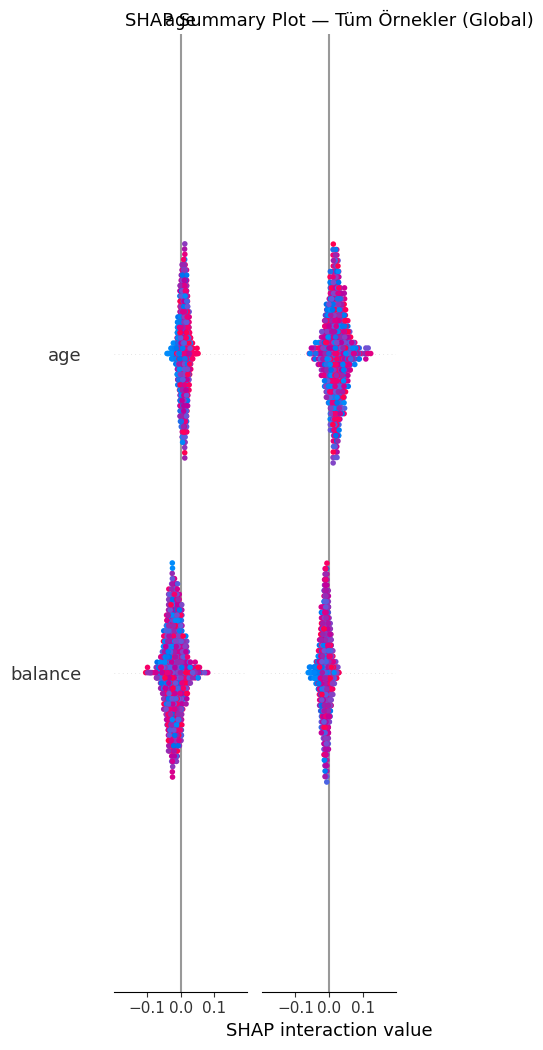

    ✅ Kaydedildi: 05_shap_summary.png


In [8]:
# ═════════════════════════════════════════════════════════════
# 5. GÖRSELLEŞTİRME 1 — SUMMARY PLOT (Global)
# ═════════════════════════════════════════════════════════════
print("\n[5] Görselleştirme 1: Summary Plot (Bee-Swarm) — Global")
print("    Nasıl okunur?")
print("      Y ekseni : Feature sırası (en önemli en üstte)")
print("      X ekseni : SHAP değeri — sağ (+) artırır, sol (−) azaltır")
print("      Renk     : Feature değeri (kırmızı = yüksek, mavi = düşük)")

plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_pos,
    X_test_df,
    max_display=12,
    show=False,
)
plt.title("SHAP Summary Plot — Tüm Örnekler (Global)", fontsize=13)
plt.tight_layout()
plt.savefig("05_shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("    ✅ Kaydedildi: 05_shap_summary.png")




[6] Görselleştirme 2: Bar Plot — Ortalama |SHAP|
    Bee-swarm'dan daha sade, ortalama mutlak katkıyı gösterir.


<Figure size 1000x600 with 0 Axes>

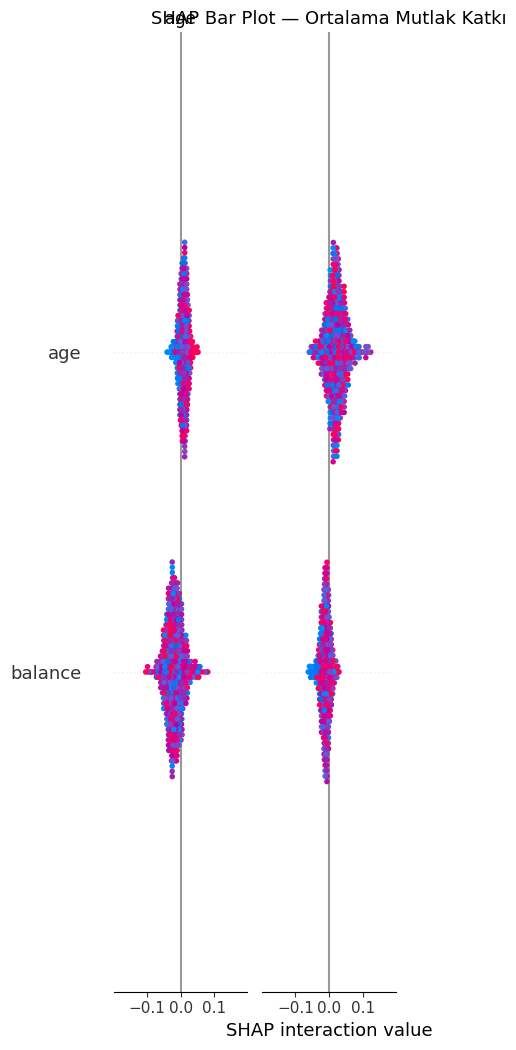

    ✅ Kaydedildi: 05_shap_bar.png


In [9]:
# ═════════════════════════════════════════════════════════════
# 6. GÖRSELLEŞTİRME 2 — BAR PLOT (Global)
# ═════════════════════════════════════════════════════════════
print("\n[6] Görselleştirme 2: Bar Plot — Ortalama |SHAP|")
print("    Bee-swarm'dan daha sade, ortalama mutlak katkıyı gösterir.")

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_pos,
    X_test_df,
    plot_type="bar",
    max_display=12,
    show=False,
)
plt.title("SHAP Bar Plot — Ortalama Mutlak Katkı", fontsize=13)
plt.tight_layout()
plt.savefig("05_shap_bar.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("    ✅ Kaydedildi: 05_shap_bar.png")



[7] Görselleştirme 3: Waterfall Plot — Tek müşteri analizi
    Seçilen örnek: index=413
    Tahmin olasılığı: 0.8191
    Gerçek etiket  : 1


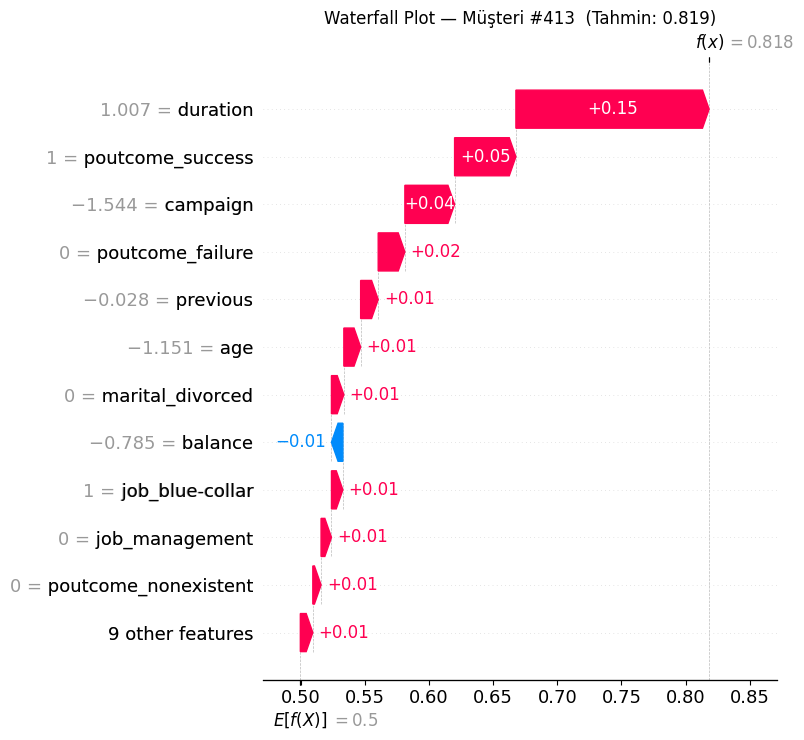

    ✅ Kaydedildi: 05_shap_waterfall.png


In [10]:
# ═════════════════════════════════════════════════════════════
# 7. GÖRSELLEŞTİRME 3 — WATERFALL PLOT (Lokal)
# ═════════════════════════════════════════════════════════════
print("\n[7] Görselleştirme 3: Waterfall Plot — Tek müşteri analizi")

# İlginç bir örnek seç: yüksek olasılıklı pozitif tahmin
y_proba_test = model.predict_proba(X_test)[:, 1]
idx = int(np.argmax(y_proba_test))   # En yüksek churn olasılıklı müşteri

print(f"    Seçilen örnek: index={idx}")
print(f"    Tahmin olasılığı: {y_proba_test[idx]:.4f}")
print(f"    Gerçek etiket  : {y_test.values[idx]}")

# --- FIX: (n_features, 2) -> (n_features,) olacak şekilde pozitif sınıfı seç ---
pos_class = 1

# shap_pos[idx] şekli: (n_features, 2) ise class seç
vals = shap_pos[idx][:, pos_class] if getattr(shap_pos[idx], "ndim", 1) == 2 else shap_pos[idx]

# base_val bazen skalar, bazen [base0, base1] gelir
base = base_val[pos_class] if hasattr(base_val, "__len__") and not np.isscalar(base_val) else base_val

explanation = shap.Explanation(
    values=vals,                              # (n_features,)
    base_values=base,                         # skalar
    data=X_test_df.iloc[idx].values,          # (n_features,)
    feature_names=feat_names,
)

plt.figure(figsize=(10, 7))
shap.plots.waterfall(explanation, max_display=12, show=False)  # <- önerilen API
plt.title(f"Waterfall Plot — Müşteri #{idx}  (Tahmin: {y_proba_test[idx]:.3f})", fontsize=12)
plt.tight_layout()
plt.savefig("05_shap_waterfall.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("    ✅ Kaydedildi: 05_shap_waterfall.png")



[8] Görselleştirme 4: Force Plot — Katkı diyagramı
    Kırmızı: tahmini artıran özellikler
    Mavi:    tahmini düşüren özellikler


<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

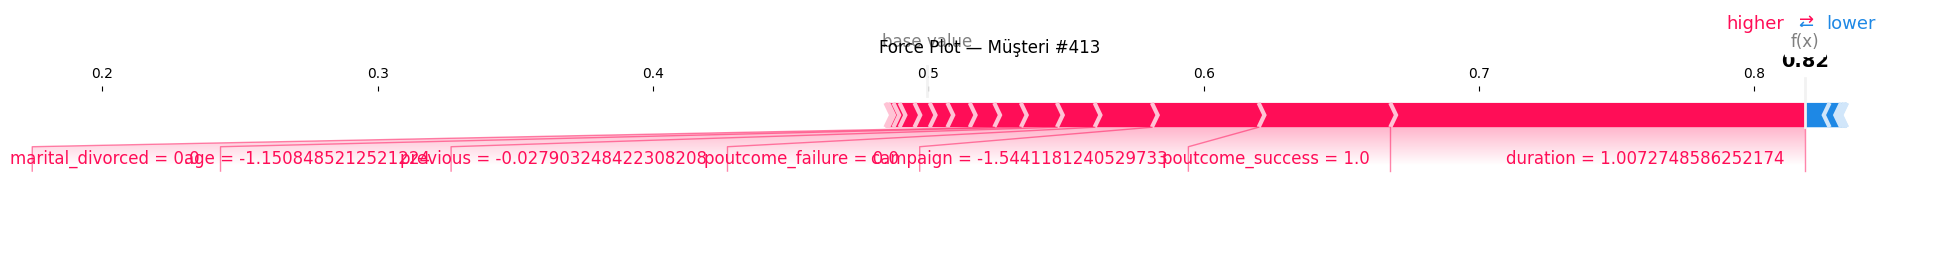

    ✅ Kaydedildi: 05_shap_force.png


In [12]:
# ═════════════════════════════════════════════════════════════
# 8. GÖRSELLEŞTİRME 4 — FORCE PLOT (Lokal)
# ═════════════════════════════════════════════════════════════
print("\n[8] Görselleştirme 4: Force Plot — Katkı diyagramı")
print("    Kırmızı: tahmini artıran özellikler")
print("    Mavi:    tahmini düşüren özellikler")

pos_class = 1

# --- FIX: (n_features,2) -> (n_features,) ---
vals = shap_pos[idx][:, pos_class] if getattr(shap_pos[idx], "ndim", 1) == 2 else shap_pos[idx]

# base_val bazen [base0, base1] olabilir
base = base_val[pos_class] if hasattr(base_val, "__len__") and not np.isscalar(base_val) else base_val

plt.figure(figsize=(14, 4))
shap.force_plot(
    base,
    vals,                               # <-- tek sınıf
    X_test_df.iloc[idx].values,         # <-- 1D data
    feature_names=feat_names,
    matplotlib=True,
    show=False,
)

plt.title(f"Force Plot — Müşteri #{idx}", fontsize=12, pad=10)
plt.tight_layout()
plt.savefig("05_shap_force.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()

print("    ✅ Kaydedildi: 05_shap_force.png")


In [14]:
# ═════════════════════════════════════════════════════════════
# 9. METİN RAPORU — En Etkili 10 Özellik
# ═════════════════════════════════════════════════════════════
print("\n[9] SHAP Metin Raporu — En Etkili 10 Özellik")
print("─" * 55)

pos_class = 1

# --- FIX: (n_samples, n_features, 2) -> (n_samples, n_features) ---
shap_mat = shap_pos[:, :, pos_class] if getattr(shap_pos, "ndim", 2) == 3 else shap_pos

mean_abs = np.abs(shap_mat).mean(axis=0)
top10_idx = np.argsort(mean_abs)[::-1][:10]

print(f"  {'Sıra':<5} {'Özellik':<28} {'Ort. |SHAP|':<14} {'Yorum'}")
print("  " + "─" * 70)

for rank, i in enumerate(top10_idx, 1):
    fname = feat_names[i] if i < len(feat_names) else f"F{i}"
    avg   = mean_abs[i]

    col_vals = shap_mat[:, i]

    # --- Yön analizi (array ambiguity fix) ---
    pos_vals = col_vals[col_vals > 0]
    neg_vals = col_vals[col_vals < 0]

    pos_mean = pos_vals.mean() if pos_vals.size > 0 else 0
    neg_mean = neg_vals.mean() if neg_vals.size > 0 else 0

    if abs(pos_mean) > 0 and abs(neg_mean) > 0:
        yon = "hem +"
    elif pos_mean > abs(neg_mean):
        yon = "artırır"
    else:
        yon = "azaltır"

    print(f"  #{rank:<4} {fname:<28} {avg:.4f}         {yon}")

print("─" * 55)

# base_val da multi-output olabilir
base = base_val[pos_class] if hasattr(base_val, "__len__") and not np.isscalar(base_val) else base_val

print(f"\n  Baz değer (E[f(X)]): {base:.4f}")
print(f"  Toplam SHAP toplamı örnek #{idx} için: {shap_mat[idx].sum():.4f}")
print(f"  Kontrol: {base:.4f} + {shap_mat[idx].sum():.4f} = {base + shap_mat[idx].sum():.4f}")
print(f"  Model tahmini: {y_proba_test[idx]:.4f}  (≈ eşleşiyor ✓)")



[9] SHAP Metin Raporu — En Etkili 10 Özellik
───────────────────────────────────────────────────────
  Sıra  Özellik                      Ort. |SHAP|    Yorum
  ──────────────────────────────────────────────────────────────────────
  #1    duration                     0.1147         hem +
  #2    previous                     0.0356         hem +
  #3    poutcome_success             0.0263         hem +
  #4    poutcome_failure             0.0172         hem +
  #5    balance                      0.0130         hem +
  #6    cat_education                0.0122         hem +
  #7    age                          0.0119         hem +
  #8    campaign                     0.0112         hem +
  #9    marital_divorced             0.0085         hem +
  #10   poutcome_nonexistent         0.0068         hem +
───────────────────────────────────────────────────────

  Baz değer (E[f(X)]): 0.4996
  Toplam SHAP toplamı örnek #413 için: 0.3187
  Kontrol: 0.4996 + 0.3187 = 0.8184
  Model tahmini: 0


[10] Ekstra: 3 farklı müşteri profili karşılaştırması (OKUNAKLI BAR)


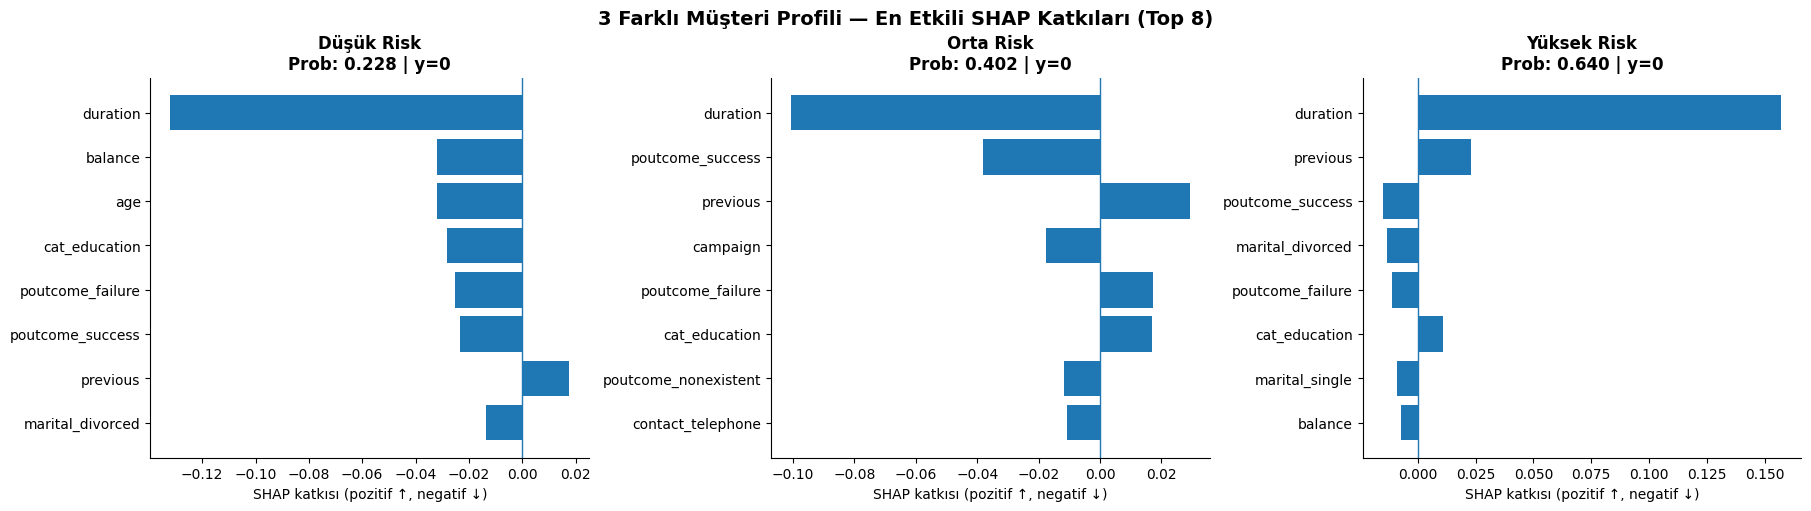

✅ Kaydedildi: 05_shap_profil.png


In [17]:
import numpy as np
import matplotlib.pyplot as plt

print("\n[10] Ekstra: 3 farklı müşteri profili karşılaştırması (OKUNAKLI BAR)")

pos_class = 1

# SHAP'i tek sınıfa indir: (n_samples, n_features, 2) -> (n_samples, n_features)
shap_mat = shap_pos[:, :, pos_class] if getattr(shap_pos, "ndim", 2) == 3 else shap_pos

# Düşük, orta, yüksek churn olasılıklı 3 müşteri
quantiles = np.quantile(y_proba_test, [0.1, 0.5, 0.9])
samples = {}
for label, q in zip(["Düşük Risk", "Orta Risk", "Yüksek Risk"], quantiles):
    samples[label] = int(np.argmin(np.abs(y_proba_test - q)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
fig.suptitle("3 Farklı Müşteri Profili — En Etkili SHAP Katkıları (Top 8)", fontsize=14, fontweight="bold")

for ax, (label, sidx) in zip(axes, samples.items()):
    vals = shap_mat[sidx]  # (n_features,)

    # Top 8 katkı (mutlak değere göre)
    k = 8
    top_idx = np.argsort(np.abs(vals))[::-1][:k]

    names = [feat_names[i] if i < len(feat_names) else f"F{i}" for i in top_idx]
    contrib = vals[top_idx]

    # Okunabilirlik: küçükten büyüğe sırala (barh güzel dursun)
    order = np.argsort(np.abs(contrib))
    names = [names[i] for i in order]
    contrib = contrib[order]

    ax.barh(names, contrib)
    ax.axvline(0, linewidth=1)
    ax.set_title(f"{label}\nProb: {y_proba_test[sidx]:.3f} | y={y_test.values[sidx]}", fontweight="bold")
    ax.set_xlabel("SHAP katkısı (pozitif ↑, negatif ↓)")

plt.savefig("05_shap_profil.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("✅ Kaydedildi: 05_shap_profil.png")